# Analysis of alloreactive T cell dataset

Analyzing data from [Fu et al. 2024](https://doi.org/10.1084/jem.20230930)

In [1]:
import glob
import os
import re
import warnings
from itertools import combinations

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

from utils import compute_gene_overlaps, cosine, euclidean

In [2]:
# Create figure and output directories
DATA_DIR = "../data/fu"
FIG_DIR = "../figures/fu"
OUT_DIR = "../out/fu"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

PALETTE = [
    "#CC6677",
    "#332288",
    "#DDCC77",
    "#117733",
    "#88CCEE",
    "#882255",
    "#44AA99",
    "#999933",
    "#AA4499",
    "#DDDDDD",
]

In [3]:
# Load the data
samples_single_end = ["MJ001", "MJ002", "MJ003", "MJ017", "MJ016"]

# Cell Ranger and velocyto: Need to make genes unique before merging
adatas_cr = {
    re.search("/cellranger/(.*)/outs", file).group(1): sc.read_10x_h5(file)
    for file in glob.glob(
        os.path.join(DATA_DIR, "cellranger/*/outs/filtered_feature_bc_matrix.h5")
    )
}
for adata in adatas_cr.values():
    adata.var_names_make_unique()

adatas_velo = {
    re.search("/cellranger/(.*)/velocyto", file).group(1): sc.read_loom(file)
    for file in glob.glob(os.path.join(DATA_DIR, "cellranger/*/velocyto/*.loom"))
}
for adata in adatas_velo.values():
    adata.var_names_make_unique()

adatas_star = {
    re.search("/starsolo/(.*)/Solo.out", file).group(1): sc.read_mtx(file).T
    for file in glob.glob(
        os.path.join(DATA_DIR, "starsolo/*/Solo.out/Gene/filtered/matrix.mtx")
    )
}
for key, adata in adatas_star.items():
    adata.var = pd.read_csv(
        os.path.join(DATA_DIR, f"starsolo/{key}/Solo.out/Gene/filtered/features.tsv"),
        sep="\t",
        header=None,
        index_col=1,
        names=["gene_ids", "feature_types"],
    )
    adata.var_names_make_unique()
    adata.obs_names = pd.read_csv(
        os.path.join(DATA_DIR, f"starsolo/{key}/Solo.out/Gene/filtered/barcodes.tsv"),
        sep="\t",
        header=None,
    )[0]
    for splice_state in ["spliced", "unspliced", "ambiguous"]:
        adata.layers[splice_state] = sc.read_mtx(
            os.path.join(
                DATA_DIR,
                f"starsolo/{key}/Solo.out/Velocyto/filtered/{splice_state}.mtx",
            )
        ).X.T

adatas = {
    "reference": sc.read_h5ad(os.path.join(DATA_DIR, "reference/adata.h5ad")),
    "velocyto": ad.concat(adatas_velo, index_unique="_", label="sample", merge="same"),
    "alevin-fry": ad.concat(
        {
            re.search("/alevin/(.*)/quant_res", file).group(1): sc.read_h5ad(file)
            for file in glob.glob(
                os.path.join(DATA_DIR, "alevin/*/quant_res/adata.h5ad")
            )
        },
        index_unique="_",
        label="sample",
        merge="same",
    ),
    "starsolo": ad.concat(adatas_star, index_unique="_", label="sample", merge="same"),
    "tidesurf": ad.concat(
        {
            re.search("/tidesurf/(.*)/tidesurf.h5ad", file).group(1): sc.read_h5ad(file)
            for file in glob.glob(os.path.join(DATA_DIR, "tidesurf/*/tidesurf.h5ad"))
        },
        index_unique="_",
        label="sample",
        merge="same",
    ),
    "cellranger": ad.concat(adatas_cr, index_unique="_", label="sample"),
}

del adatas_cr
del adatas_velo
del adatas_star

for method, adata in adatas.items():
    if method == "reference":
        adata.obs["sample"] = (
            adata.obs["orig.ident"]
            .map(
                {
                    "Pt15_POD1194": "MJ001",
                    "Pt13_POD1032_IEL": "MJ002",
                    "Pt13_POD1032_LPL": "MJ003",
                    "Pt14_POD1764": "MJ005",
                    "Pt21_POD626": "MJ006",
                    "D251": "MJ007",
                    "Pt04_POD1606_IEL": "MJ008",
                    "Pt04_POD1606_LPL": "MJ009",
                    "Pt16_POD1004_IEL": "MJ016",
                    "Pt16_POD1004_LPL": "MJ017",
                    "Pt21_POD1145_IEL": "MJ018",
                    "Pt21_POD1145_LPL": "MJ019",
                }
            )
            .astype(str)
        )
    adata.obs["alignment_type"] = "PE"
    adata.obs.loc[adata.obs["sample"].isin(samples_single_end), "alignment_type"] = "SE"
    adata.var_names_make_unique()
    print(f"=====\n{method}\n")
    display(adata)
    print()

=====
reference



AnnData object with n_obs × n_vars = 51504 × 22684
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pos', 'mt', 'clonotype', 'pre', 'post', 'pre_post', 'categories', 'nCount_SCT', 'nFeature_SCT', 'immune', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'integrated_snn_res.0.5', 'seurat_clusters', 'integrated_snn_res.0.6', 'groups', 'repos', 'cate', 'cat', 'barcode', 'UMAP_1', 'UMAP_2', 'sample', 'alignment_type'
    var: 'highly_variable'
    uns: 'groups_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'


=====
velocyto



AnnData object with n_obs × n_vars = 102316 × 36601
    obs: 'sample', 'alignment_type'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'


=====
alevin-fry



AnnData object with n_obs × n_vars = 110145 × 36601
    obs: 'barcodes', 'sample', 'alignment_type'
    var: 'gene_id', 'gene_name'
    layers: 'ambiguous', 'spliced', 'unspliced'


=====
starsolo



AnnData object with n_obs × n_vars = 91257 × 36601
    obs: 'sample', 'alignment_type'
    var: 'gene_ids', 'feature_types'
    layers: 'spliced', 'unspliced', 'ambiguous'


=====
tidesurf



AnnData object with n_obs × n_vars = 102316 × 14899
    obs: 'sample', 'alignment_type'
    layers: 'ambiguous', 'spliced', 'unspliced'


=====
cellranger



AnnData object with n_obs × n_vars = 102316 × 36601
    obs: 'sample', 'alignment_type'

In [4]:
# Change format of obs_names and get common cells
adatas["reference"].obs_names = adatas["reference"].obs_names.str.replace(
    "_\d+$", "_", regex=True
) + adatas["reference"].obs["sample"].astype(str)
adatas["reference"].obs.drop(columns="barcode", inplace=True)
adatas["velocyto"].obs_names = (
    adatas["velocyto"]
    .obs_names.str.replace("^.*:", "", regex=True)
    .str.replace("x_", "-1_", regex=True)
)
adatas["alevin-fry"].obs_names = adatas["alevin-fry"].obs_names.str.replace("_", "-1_")
adatas["starsolo"].obs_names = adatas["starsolo"].obs_names.str.replace("_", "-1_")
adatas["alevin-fry"].obs.drop(columns="barcodes", inplace=True)
common_cells = pd.Index(
    set.intersection(*[set(adata.obs_names) for adata in adatas.values()])
)
print(len(common_cells))

50314


In [5]:
# Velocyto and Cell Ranger have the same cells and genes
# -> add Cell Ranger counts to velocyto adata as X
adatas["velocyto"].X = adatas["cellranger"][
    adatas["velocyto"].obs_names, adatas["velocyto"].var_names
].X.copy()

In [6]:
# Get common genes
common_genes = pd.Index(
    set.intersection(*[set(adata.var_names) for adata in adatas.values()])
)
print(len(common_genes))

14411


In [7]:
# Subset to common cells
adatas_sub = {method: adata[common_cells, :] for method, adata in adatas.items()}

In [8]:
# Subset to common genes
adatas_common = {method: adata[:, common_genes] for method, adata in adatas_sub.items()}

In [9]:
# Save raw AnnData before processing
os.makedirs(os.path.join(DATA_DIR, "adata"), exist_ok=True)
for key, adata in adatas_sub.items():
    if key == "reference":
        continue
    adata.write_h5ad(
        os.path.join(DATA_DIR, "adata", f"adata_raw_{key}.h5ad"), compression="gzip"
    )

## Initial analysis: Counts

Comparison of methods w.r.t. total counts as well as spliced/ambiguous/unspliced counts per cell.

In [10]:
# Total counts per cell and count difference
total_counts = pd.concat(
    [
        pd.DataFrame(
            data=dict(
                {
                    method: np.asarray(
                        adata.layers["spliced"].sum(axis=1)
                        + adata.layers["unspliced"].sum(axis=1)
                        + adata.layers["ambiguous"].sum(axis=1)
                    ).flatten()
                    if method == "velocyto"
                    else np.asarray(adata.X.sum(axis=1)).flatten()
                    for method, adata in adatas_sub.items()
                    if method != "reference"
                },
                genes="all",
                alignment_type=adatas_sub["reference"].obs["alignment_type"],
            )
        ),
        pd.DataFrame(
            data=dict(
                {
                    method: np.asarray(
                        adata.layers["spliced"].sum(axis=1)
                        + adata.layers["unspliced"].sum(axis=1)
                        + adata.layers["ambiguous"].sum(axis=1)
                    ).flatten()
                    if method == "velocyto"
                    else np.asarray(adata.X.sum(axis=1)).flatten()
                    for method, adata in adatas_common.items()
                    if method != "reference"
                },
                genes="common",
                alignment_type=adatas_sub["reference"].obs["alignment_type"],
            )
        ),
    ]
)

counts_diff = pd.DataFrame(
    data={
        "velocyto": total_counts["cellranger"] - total_counts["velocyto"],
        "alevin-fry": total_counts["cellranger"] - total_counts["alevin-fry"],
        "starsolo": total_counts["cellranger"] - total_counts["starsolo"],
        "tidesurf": total_counts["cellranger"] - total_counts["tidesurf"],
        "genes": total_counts["genes"],
        "alignment_type": total_counts["alignment_type"],
    }
)

total_counts = total_counts.melt(
    id_vars=["genes", "alignment_type"], var_name="method", value_name="counts"
)
total_counts.to_parquet(
    os.path.join(OUT_DIR, "total_counts.parquet.gz"), compression="gzip"
)
counts_diff = counts_diff.melt(
    id_vars=["genes", "alignment_type"], var_name="method", value_name="difference"
)
counts_diff.to_parquet(
    os.path.join(OUT_DIR, "counts_diff.parquet.gz"), compression="gzip"
)

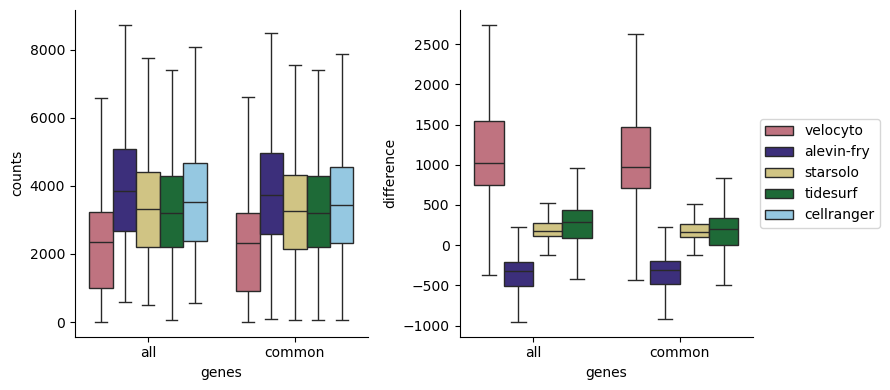

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

sns.boxplot(
    data=total_counts,
    x="genes",
    y="counts",
    hue="method",
    hue_order=["velocyto", "alevin-fry", "starsolo", "tidesurf", "cellranger"],
    palette=PALETTE,
    showfliers=False,
    ax=axs[0],
)
axs[0].get_legend().remove()

sns.boxplot(
    data=counts_diff,
    x="genes",
    y="difference",
    hue="method",
    hue_order=["velocyto", "alevin-fry", "starsolo", "tidesurf"],
    palette=PALETTE,
    showfliers=False,
    ax=axs[1],
)

handles, labels = axs[0].get_legend_handles_labels()
axs[1].legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)

fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "total_counts.png"), dpi=200)

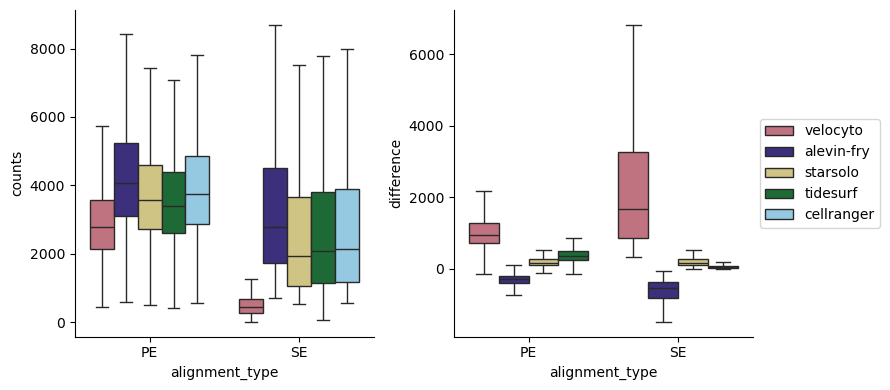

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

sns.boxplot(
    data=total_counts[total_counts.genes == "all"],
    x="alignment_type",
    y="counts",
    hue="method",
    hue_order=["velocyto", "alevin-fry", "starsolo", "tidesurf", "cellranger"],
    palette=PALETTE,
    showfliers=False,
    ax=axs[0],
)
axs[0].get_legend().remove()

sns.boxplot(
    data=counts_diff[counts_diff.genes == "all"],
    x="alignment_type",
    y="difference",
    hue="method",
    hue_order=["velocyto", "alevin-fry", "starsolo", "tidesurf"],
    palette=PALETTE,
    showfliers=False,
    ax=axs[1],
)

handles, labels = axs[0].get_legend_handles_labels()
axs[1].legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)

fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "total_counts_by_alignment.png"), dpi=200)

In [13]:
# Spliced, unspliced, ambiguous per cell
spliced_unspliced_counts = pd.concat(
    [
        pd.DataFrame(
            data={
                "spliced": np.asarray(adata.layers["spliced"].sum(axis=1)).flatten(),
                "unspliced": np.asarray(
                    adata.layers["unspliced"].sum(axis=1)
                ).flatten(),
                "ambiguous": np.asarray(
                    adata.layers["ambiguous"].sum(axis=1)
                ).flatten(),
                "method": method,
                "genes": "all",
                "alignment_type": adata.obs["alignment_type"],
            }
        )
        for method, adata in adatas_sub.items()
        if method not in ["reference", "cellranger"]
    ]
    + [
        pd.DataFrame(
            data={
                "spliced": np.asarray(adata.layers["spliced"].sum(axis=1)).flatten(),
                "unspliced": np.asarray(
                    adata.layers["unspliced"].sum(axis=1)
                ).flatten(),
                "ambiguous": np.asarray(
                    adata.layers["ambiguous"].sum(axis=1)
                ).flatten(),
                "method": method,
                "genes": "common",
                "alignment_type": adata.obs["alignment_type"],
            }
        )
        for method, adata in adatas_common.items()
        if method not in ["reference", "cellranger"]
    ]
)

totals = (
    spliced_unspliced_counts["spliced"]
    + spliced_unspliced_counts["unspliced"]
    + spliced_unspliced_counts["ambiguous"]
)

spliced_unspliced_ratios = pd.DataFrame(
    data={
        "spliced": spliced_unspliced_counts["spliced"] / totals,
        "unspliced": spliced_unspliced_counts["unspliced"] / totals,
        "ambiguous": spliced_unspliced_counts["ambiguous"] / totals,
        "genes": spliced_unspliced_counts["genes"],
        "alignment_type": spliced_unspliced_counts["alignment_type"],
        "method": spliced_unspliced_counts["method"],
    }
)

spliced_unspliced_counts = spliced_unspliced_counts.melt(
    id_vars=["genes", "alignment_type", "method"],
    var_name="splice_state",
    value_name="counts",
)
spliced_unspliced_counts.to_parquet(
    os.path.join(OUT_DIR, "spliced_unspliced_counts.parquet.gz"), compression="gzip"
)
spliced_unspliced_ratios = spliced_unspliced_ratios.melt(
    id_vars=["genes", "alignment_type", "method"],
    var_name="splice_state",
    value_name="ratio",
)
spliced_unspliced_ratios.to_parquet(
    os.path.join(OUT_DIR, "spliced_unspliced_ratios.parquet.gz"), compression="gzip"
)

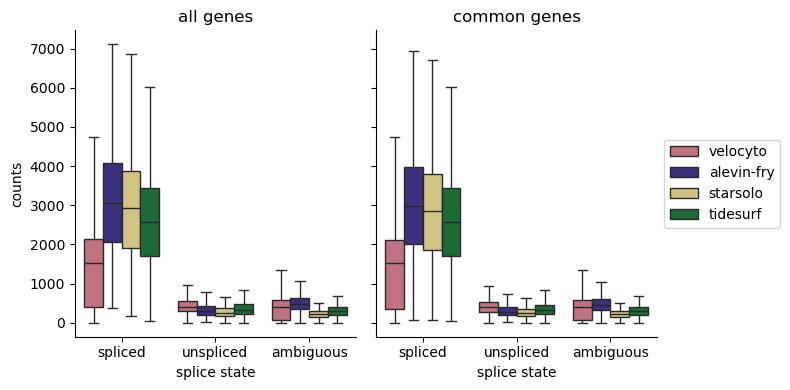

In [14]:
# Boxplots of spliced/unspliced/ambiguous counts
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey="row", sharex=True)

for i, subset in enumerate(["all", "common"]):
    sns.boxplot(
        data=spliced_unspliced_counts[spliced_unspliced_counts["genes"] == subset],
        x="splice_state",
        y="counts",
        hue="method",
        palette=PALETTE,
        showfliers=False,
        ax=axs[i],
    )
    axs[i].set_title(f"{subset} genes")
    axs[i].set_xlabel("splice state")
    axs[i].get_legend().remove()

axs[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_counts.png"), dpi=200)

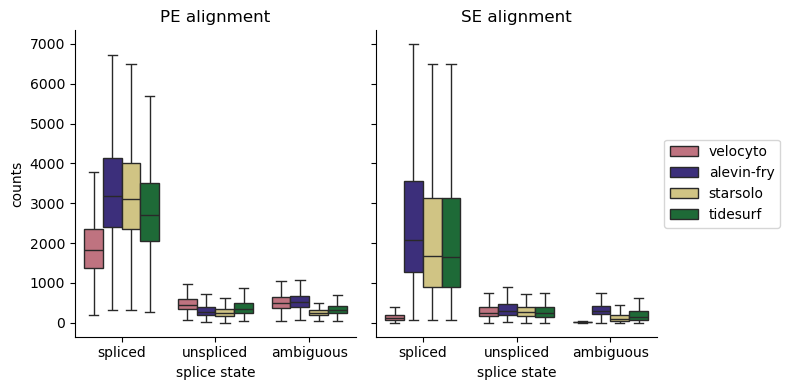

In [15]:
# Boxplots of spliced/unspliced/ambiguous counts
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey="row", sharex=True)

for i, subset in enumerate(["PE", "SE"]):
    sns.boxplot(
        data=spliced_unspliced_counts[
            spliced_unspliced_counts["alignment_type"] == subset
        ],
        x="splice_state",
        y="counts",
        hue="method",
        palette=PALETTE,
        showfliers=False,
        ax=axs[i],
    )
    axs[i].set_title(f"{subset} alignment")
    axs[i].set_xlabel("splice state")
    axs[i].get_legend().remove()

axs[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_counts_by_alignment.png"), dpi=200)

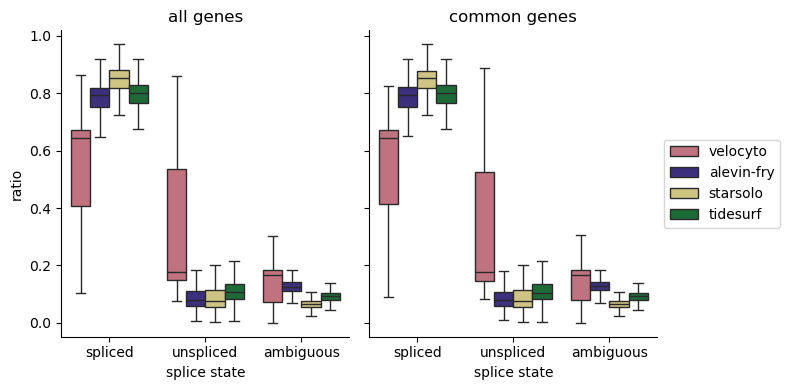

In [16]:
# Boxplots of spliced/unspliced/ambiguous ratios
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey="row", sharex=True)

for i, subset in enumerate(["all", "common"]):
    sns.boxplot(
        data=spliced_unspliced_ratios[spliced_unspliced_ratios["genes"] == subset],
        x="splice_state",
        y="ratio",
        hue="method",
        palette=PALETTE,
        showfliers=False,
        ax=axs[i],
    )
    axs[i].set_title(f"{subset} genes")
    axs[i].get_legend().remove()
    axs[i].set_xlabel("splice state")

axs[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_ratios.png"), dpi=200)

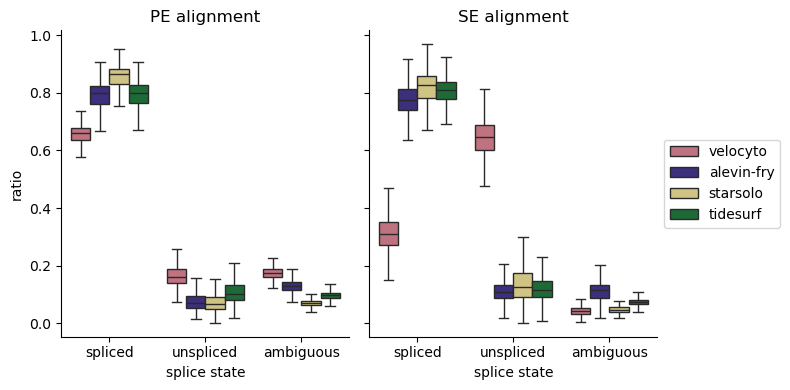

In [17]:
# Boxplots of spliced/unspliced/ambiguous ratios
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey="row", sharex=True)

for i, subset in enumerate(["PE", "SE"]):
    sns.boxplot(
        data=spliced_unspliced_ratios[
            spliced_unspliced_ratios["alignment_type"] == subset
        ],
        x="splice_state",
        y="ratio",
        hue="method",
        palette=PALETTE,
        showfliers=False,
        ax=axs[i],
    )
    axs[i].set_title(f"{subset} alignment")
    axs[i].get_legend().remove()
    axs[i].set_xlabel("splice state")

axs[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_ratios_by_alignment.png"), dpi=200)

In [18]:
spliced_unspliced_ratios[spliced_unspliced_ratios["genes"] == "common"].groupby(
    ["method", "splice_state", "alignment_type"]
).mean(numeric_only=True)

ratio
method     splice_state alignment_type          
alevin-fry ambiguous    PE              0.133472
                        SE              0.112655
           spliced      PE              0.783713
                        SE              0.772340
           unspliced    PE              0.082815
                        SE              0.115005
starsolo   ambiguous    PE              0.071754
                        SE              0.049165
           spliced      PE              0.848329
                        SE              0.812571
           unspliced    PE              0.079917
                        SE              0.138264
tidesurf   ambiguous    PE              0.098332
                        SE              0.074879
           spliced      PE              0.785931
                        SE              0.801251
           unspliced    PE              0.115736
                        SE              0.123869
velocyto   ambiguous    PE              0.176873
                        SE              0.047296
           spliced      PE              0.651568
                        SE              0.311014
           unspliced    PE              0.171559
                        SE              0.641690

In [19]:
spliced_unspliced_sums_ts_all = pd.DataFrame(
    data={
        "spliced": np.asarray(
            adatas_sub["tidesurf"].layers["spliced"].sum(axis=1)
        ).flatten(),
        "unspliced": np.asarray(
            adatas_sub["tidesurf"].layers["unspliced"].sum(axis=1)
        ).flatten(),
        "ambiguous": np.asarray(
            adatas_sub["tidesurf"].layers["ambiguous"].sum(axis=1)
        ).flatten(),
    }
)
spliced_unspliced_sums_ts_common = pd.DataFrame(
    data={
        "spliced": np.asarray(
            adatas_common["tidesurf"].layers["spliced"].sum(axis=1)
        ).flatten(),
        "unspliced": np.asarray(
            adatas_common["tidesurf"].layers["unspliced"].sum(axis=1)
        ).flatten(),
        "ambiguous": np.asarray(
            adatas_common["tidesurf"].layers["ambiguous"].sum(axis=1)
        ).flatten(),
    }
)

spliced_unspliced_diff = pd.concat(
    [
        pd.DataFrame(
            data={
                "spliced": (
                    np.asarray(
                        adatas_sub[method].layers["spliced"].sum(axis=1)
                    ).flatten()
                    - spliced_unspliced_sums_ts_all["spliced"]
                ),
                "unspliced": (
                    np.asarray(
                        adatas_sub[method].layers["unspliced"].sum(axis=1)
                    ).flatten()
                    - spliced_unspliced_sums_ts_all["unspliced"]
                ),
                "ambiguous": (
                    np.asarray(
                        adatas_sub[method].layers["ambiguous"].sum(axis=1)
                    ).flatten()
                    - spliced_unspliced_sums_ts_all["ambiguous"]
                ),
                "genes": "all",
                "method": method,
                "alignment_type": adatas_sub[method].obs["alignment_type"],
            }
        )
        for method in ["velocyto", "alevin-fry", "starsolo"]
    ]
    + [
        pd.DataFrame(
            data={
                "spliced": (
                    np.asarray(
                        adatas_common[method].layers["spliced"].sum(axis=1)
                    ).flatten()
                    - spliced_unspliced_sums_ts_all["spliced"]
                ),
                "unspliced": (
                    np.asarray(
                        adatas_common[method].layers["unspliced"].sum(axis=1)
                    ).flatten()
                    - spliced_unspliced_sums_ts_all["unspliced"]
                ),
                "ambiguous": (
                    np.asarray(
                        adatas_common[method].layers["ambiguous"].sum(axis=1)
                    ).flatten()
                    - spliced_unspliced_sums_ts_all["ambiguous"]
                ),
                "genes": "common",
                "method": method,
                "alignment_type": adatas_common[method].obs["alignment_type"],
            }
        )
        for method in ["velocyto", "alevin-fry", "starsolo"]
    ]
).melt(
    id_vars=["genes", "method", "alignment_type"],
    var_name="splice_state",
    value_name="diff",
)
spliced_unspliced_diff.to_parquet(
    os.path.join(OUT_DIR, "spliced_unspliced_diff.parquet.gz"), compression="gzip"
)

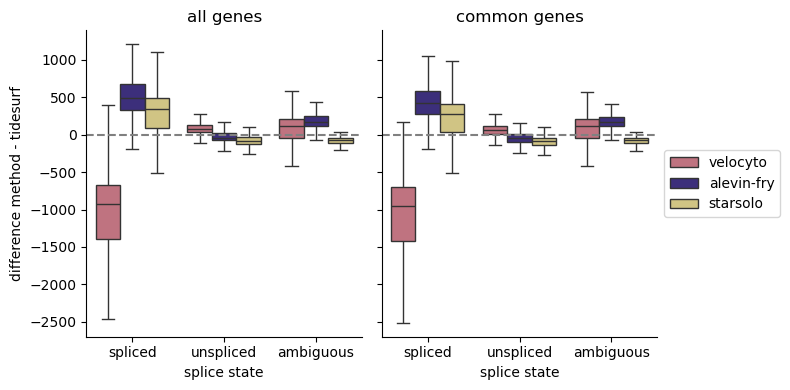

In [20]:
# Boxplots of spliced/unspliced/ambiguous counts
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey="row", sharex=True)

for i, subset in enumerate(["all", "common"]):
    sns.boxplot(
        data=spliced_unspliced_diff[spliced_unspliced_diff["genes"] == subset],
        x="splice_state",
        y="diff",
        hue="method",
        palette=PALETTE,
        showfliers=False,
        ax=axs[i],
    )
    axs[i].set_title(f"{subset} genes")
    axs[i].set_xlabel("splice state")
    axs[i].set_ylabel("difference method - tidesurf")
    axs[i].get_legend().remove()
    axs[i].axhline(color="grey", linestyle="--")

axs[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_diff.png"), dpi=200)

In [21]:
# Compute gene overlaps
overlapping_genes_df = compute_gene_overlaps(
    adatas["velocyto"].var[["Chromosome", "Start", "End", "Strand"]]
)

# Add combination of genes in the other direction
overlapping_genes_df_ = overlapping_genes_df.copy()
overlapping_genes_df_.rename(
    columns={
        col: re.sub("_x", "_y", col)
        for col in overlapping_genes_df_.columns
        if col.endswith("_x")
    }
    | {
        col: re.sub("_y", "_x", col)
        for col in overlapping_genes_df_.columns
        if col.endswith("_y")
    },
    inplace=True,
)
overlapping_genes_df = pd.concat([overlapping_genes_df, overlapping_genes_df_])
del overlapping_genes_df_

overlapping_genes_df = overlapping_genes_df.sort_values(
    by="overlap_relative_gene_x", ascending=False
).reset_index(drop=True)

In [22]:
# Basic checks for the results
assert np.all(overlapping_genes_df.Strand_x != overlapping_genes_df.Strand_y)
assert np.all(overlapping_genes_df.Chromosome_x == overlapping_genes_df.Chromosome_y)
assert np.all(overlapping_genes_df.overlap_bases > 0)

In [23]:
overlapping_genes_df["pearsonr"] = stats.pearsonr(
    adatas_sub["velocyto"][:, overlapping_genes_df.Gene_x].X.toarray(),
    adatas_sub["velocyto"][:, overlapping_genes_df.Gene_y]
    .layers["unspliced"]
    .toarray(),
    axis=0,
)[0]
for subset in ["PE", "SE"]:
    overlapping_genes_df[f"pearsonr_{subset.lower()}"] = stats.pearsonr(
        adatas_sub["velocyto"][
            adatas_sub["velocyto"].obs.alignment_type == subset,
            overlapping_genes_df.Gene_x,
        ].X.toarray(),
        adatas_sub["velocyto"][
            adatas_sub["velocyto"].obs.alignment_type == subset,
            overlapping_genes_df.Gene_y,
        ]
        .layers["unspliced"]
        .toarray(),
        axis=0,
    )[0]
overlapping_genes_df = overlapping_genes_df.melt(
    id_vars=[
        col
        for col in overlapping_genes_df.columns
        if col not in ["pearsonr", "pearsonr_pe", "pearsonr_se"]
    ],
    value_vars=["pearsonr", "pearsonr_pe", "pearsonr_se"],
    var_name="alignment_type",
)
overlapping_genes_df["alignment_type"] = overlapping_genes_df["alignment_type"].map(
    {"pearsonr": "both", "pearsonr_pe": "PE", "pearsonr_se": "SE"}
)
overlapping_genes_df.rename(columns={"value": "pearsonr"}, inplace=True)
overlapping_genes_df.reset_index(drop=True, inplace=True)
overlapping_genes_df.to_parquet(
    os.path.join(OUT_DIR, "gene_overlaps.parquet.gz"), compression="gzip"
)

In [24]:
# Create dictionary for easier comparisons
comp_dict = {
    "tidesurf_velocyto": (adatas_common["tidesurf"], adatas_common["velocyto"]),
    "tidesurf_alevin-fry": (adatas_common["tidesurf"], adatas_common["alevin-fry"]),
    "tidesurf_starsolo": (adatas_common["tidesurf"], adatas_common["starsolo"]),
    "velocyto_alevin-fry": (adatas_common["velocyto"], adatas_common["alevin-fry"]),
    "velocyto_starsolo": (adatas_common["velocyto"], adatas_common["starsolo"]),
    "alevin-fry_starsolo": (adatas_common["alevin-fry"], adatas_common["starsolo"]),
}

In [25]:
# Pearson correlation of spliced/unspliced/ambiguous counts per gene
counts_corr = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "spliced": stats.pearsonr(
                    adata_1.layers["spliced"].toarray(),
                    adata_2.layers["spliced"].toarray(),
                    axis=0,
                )[0],
                "unspliced": stats.pearsonr(
                    adata_1.layers["unspliced"].toarray(),
                    adata_2.layers["unspliced"].toarray(),
                    axis=0,
                )[0],
                "ambiguous": stats.pearsonr(
                    adata_1.layers["ambiguous"].toarray(),
                    adata_2.layers["ambiguous"].toarray(),
                    axis=0,
                )[0],
            }
        )
        for comp, (adata_1, adata_2) in comp_dict.items()
    ]
).melt(id_vars="comparison", var_name="splice_state", value_name="pearsonr")
counts_corr.to_parquet(
    os.path.join(OUT_DIR, "spliced_unspliced_corr.parquet.gz"), compression="gzip"
)

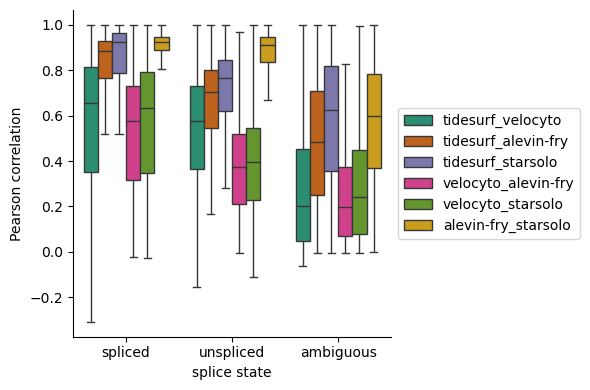

In [26]:
# Boxplots of correlations for spliced/unspliced/ambiguous counts
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(
    data=counts_corr,
    x="splice_state",
    y="pearsonr",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax,
)
ax.set_xlabel("splice state")
ax.set_ylabel("Pearson correlation")

ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_corr.png"), dpi=200)

In [27]:
# Cosine similarity of spliced/unspliced/ambiguous counts per cell
counts_cosine = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "spliced": cosine(
                    adata_1.layers["spliced"].toarray(),
                    adata_2.layers["spliced"].toarray(),
                    axis=1,
                ),
                "unspliced": cosine(
                    adata_1.layers["unspliced"].toarray(),
                    adata_2.layers["unspliced"].toarray(),
                    axis=1,
                ),
                "ambiguous": cosine(
                    adata_1.layers["ambiguous"].toarray(),
                    adata_2.layers["ambiguous"].toarray(),
                    axis=1,
                ),
            }
        )
        for comp, (adata_1, adata_2) in comp_dict.items()
    ]
).melt(id_vars="comparison", var_name="splice_state", value_name="cosine_similarity")
counts_cosine.to_parquet(
    os.path.join(OUT_DIR, "spliced_unspliced_cosine.parquet.gz"), compression="gzip"
)

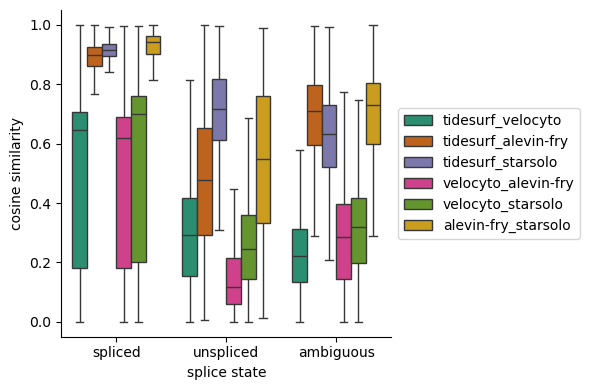

In [28]:
# Boxplots of cosine similarities for spliced/unspliced/ambiguous counts
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(
    data=counts_cosine,
    x="splice_state",
    y="cosine_similarity",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax,
)
ax.set_xlabel("splice state")
ax.set_ylabel("cosine similarity")

ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_cosine.png"), dpi=200)

In [29]:
# Euclidean distance of spliced/unspliced/ambiguous counts per cell
counts_euclidean = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "spliced": euclidean(
                    adata_1.layers["spliced"].toarray(),
                    adata_2.layers["spliced"].toarray(),
                    axis=1,
                ),
                "unspliced": euclidean(
                    adata_1.layers["unspliced"].toarray(),
                    adata_2.layers["unspliced"].toarray(),
                    axis=1,
                ),
                "ambiguous": euclidean(
                    adata_1.layers["ambiguous"].toarray(),
                    adata_2.layers["ambiguous"].toarray(),
                    axis=1,
                ),
            }
        )
        for comp, (adata_1, adata_2) in comp_dict.items()
    ]
).melt(id_vars="comparison", var_name="splice_state", value_name="euclidean_distance")
counts_euclidean.to_parquet(
    os.path.join(OUT_DIR, "spliced_unspliced_euclidean.parquet.gz"), compression="gzip"
)

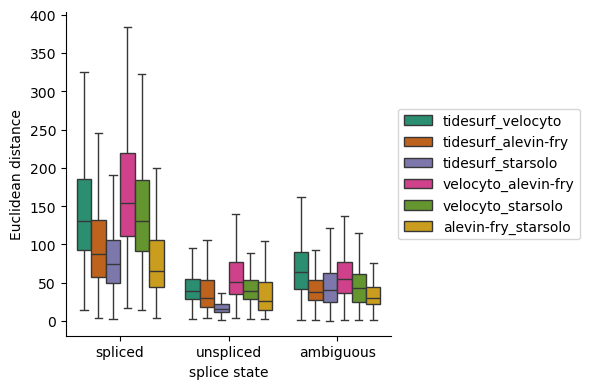

In [30]:
# Boxplots of Euclidean distances for spliced/unspliced/ambiguous counts
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(
    data=counts_euclidean,
    x="splice_state",
    y="euclidean_distance",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax,
)
ax.set_xlabel("splice state")
ax.set_ylabel("Euclidean distance")

ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "spliced_unspliced_euclidean.png"), dpi=200)

In [38]:
# Pearson correlation with Cell Ranger per gene
counts_corr_cr = pd.concat(
    [
        pd.DataFrame(
            data={
                "method": method,
                "pearsonr": stats.pearsonr(
                    (
                        adata.layers["spliced"]
                        + adata.layers["unspliced"]
                        + adata.layers["ambiguous"]
                    ).toarray()
                    if method == "velocyto"
                    else adata.X.toarray(),
                    adatas_common["cellranger"].X.toarray(),
                    axis=0,
                )[0],
                "alignment_type": "both",
            }
        )
        for method, adata in adatas_common.items()
        if method not in ["reference", "cellranger"]
    ]
    + [
        pd.DataFrame(
            data={
                "method": method,
                "pearsonr": stats.pearsonr(
                    (
                        adata[adata.obs.alignment_type == "PE"].layers["spliced"]
                        + adata[adata.obs.alignment_type == "PE"].layers["unspliced"]
                        + adata[adata.obs.alignment_type == "PE"].layers["ambiguous"]
                    ).toarray()
                    if method == "velocyto"
                    else adata[adata.obs.alignment_type == "PE"].X.toarray(),
                    adatas_common["cellranger"][
                        adatas_common["cellranger"].obs.alignment_type == "PE"
                    ].X.toarray(),
                    axis=0,
                )[0],
                "alignment_type": "PE",
            }
        )
        for method, adata in adatas_common.items()
        if method not in ["reference", "cellranger"]
    ]
    + [
        pd.DataFrame(
            data={
                "method": method,
                "pearsonr": stats.pearsonr(
                    (
                        adata[adata.obs.alignment_type == "SE"].layers["spliced"]
                        + adata[adata.obs.alignment_type == "SE"].layers["unspliced"]
                        + adata[adata.obs.alignment_type == "SE"].layers["ambiguous"]
                    ).toarray()
                    if method == "velocyto"
                    else adata[adata.obs.alignment_type == "SE"].X.toarray(),
                    adatas_common["cellranger"][
                        adatas_common["cellranger"].obs.alignment_type == "SE"
                    ].X.toarray(),
                    axis=0,
                )[0],
                "alignment_type": "SE",
            }
        )
        for method, adata in adatas_common.items()
        if method not in ["reference", "cellranger"]
    ]
).reset_index(drop=True)
counts_corr_cr.to_parquet(
    os.path.join(OUT_DIR, "counts_corr_cellranger.parquet.gz"), compression="gzip"
)

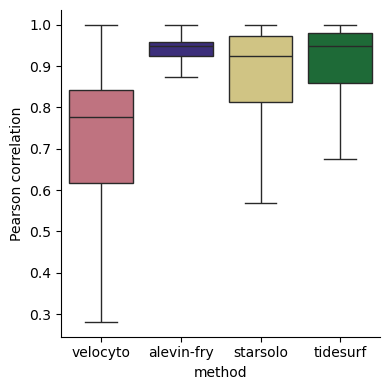

In [32]:
# Boxplots of correlations with Cell Ranger
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=counts_corr_cr,
    x="method",
    y="pearsonr",
    hue="method",
    palette=PALETTE,
    showfliers=False,
    ax=ax,
)
ax.set_ylabel("Pearson correlation")


sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "counts_corr_cellranger.png"), dpi=200)

In [33]:
# Cosine similarity with Cell Ranger per cell
counts_cosine_cr = pd.concat(
    [
        pd.DataFrame(
            data={
                "method": method,
                "cosine_similarity": cosine(
                    (
                        adata.layers["spliced"]
                        + adata.layers["unspliced"]
                        + adata.layers["ambiguous"]
                    ).toarray()
                    if method == "velocyto"
                    else adata.X.toarray(),
                    adatas_common["cellranger"].X.toarray(),
                    axis=1,
                ),
            }
        )
        for method, adata in adatas_common.items()
        if method not in ["reference", "cellranger"]
    ]
).reset_index(drop=True)
counts_cosine_cr.to_parquet(
    os.path.join(OUT_DIR, "counts_cosine_cellranger.parquet.gz"), compression="gzip"
)

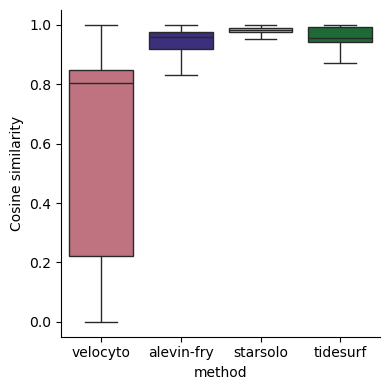

In [34]:
# Boxplots of cosine similarities with Cell Ranger
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=counts_cosine_cr,
    x="method",
    y="cosine_similarity",
    hue="method",
    palette=PALETTE,
    showfliers=False,
    ax=ax,
)
ax.set_ylabel("Cosine similarity")


sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "counts_cosine_cellranger.png"), dpi=200)

In [35]:
# Euclidean distance from Cell Ranger per cell
counts_euclidean_cr = pd.concat(
    [
        pd.DataFrame(
            data={
                "method": method,
                "euclidean_distance": euclidean(
                    (
                        adata.layers["spliced"]
                        + adata.layers["unspliced"]
                        + adata.layers["ambiguous"]
                    ).toarray()
                    if method == "velocyto"
                    else adata.X.toarray(),
                    adatas_common["cellranger"].X.toarray(),
                    axis=1,
                ),
            }
        )
        for method, adata in adatas_common.items()
        if method not in ["reference", "cellranger"]
    ]
).reset_index(drop=True)
counts_euclidean_cr.to_parquet(
    os.path.join(OUT_DIR, "counts_euclidean_cellranger.parquet.gz"), compression="gzip"
)

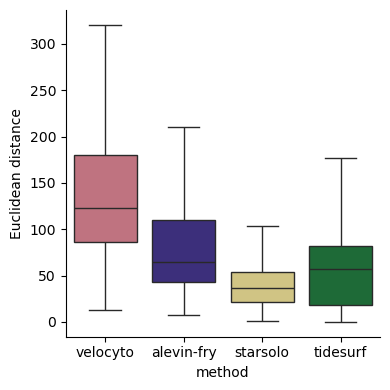

In [36]:
# Boxplots of Euclidean distances with Cell Ranger
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=counts_euclidean_cr,
    x="method",
    y="euclidean_distance",
    hue="method",
    palette=PALETTE,
    showfliers=False,
    ax=ax,
)
ax.set_ylabel("Euclidean distance")


sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "counts_euclidean_cellranger.png"), dpi=200)

## Data processing

In [37]:
adatas_velocity = {
    method: adata.copy()
    for method, adata in adatas_common.items()
    if method not in ["reference", "cellranger"]
}

In [38]:
# # Add ambiguous counts to spliced (standard for alevin-fry)
# for method, adata in adatas_velocity.items():
#     if "ambiguous" in adata.layers:
#         adata.layers["spliced"] = adata.layers["spliced"] + adata.layers["ambiguous"]
#         del adata.layers["ambiguous"]

In [39]:
# Normalize data
for adata in adatas_velocity.values():
    scv.pp.filter_genes(adata, min_shared_counts=20)
    scv.pp.normalize_per_cell(adata)
    scv.pp.filter_genes_dispersion(adata, n_top_genes=2000, subset=False)
    sc.pp.log1p(adata)

    # Add annotations from reference dataset
    adata.obs["groups"] = adatas_common["reference"].obs["groups"].copy()
    adata.uns = adatas_common["reference"].uns.copy()
    adata.obsm = adatas_common["reference"].obsm.copy()

Filtered out 6368 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Filtered out 6328 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Filtered out 6253 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Filtered out 5768 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


In [40]:
# Compute neighborhood graph for reference data
sc.pp.neighbors(adatas_common["reference"], n_pcs=30, n_neighbors=30)

# Transfer neighborhood graph to other datasets
# and compute moments
for method, adata in adatas_velocity.items():
    adata.uns["neighbors"] = adatas_common["reference"].uns["neighbors"].copy()
    adata.obsp = adatas_common["reference"].obsp.copy()
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing moments based on connectivities
    finished (0:00:29) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing moments based on connectivities
    finished (0:00:14) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing moments based on connectivities
    finished (0:00:23) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing moments based on connectivities
    finished (0:00:16) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [41]:
# Compute RNA velocity
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for adata in adatas_velocity.values():
        scv.tl.velocity(adata)
        scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:22) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/50314 [00:00<?, ?cells/s]

    finished (0:01:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:24) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/50314 [00:00<?, ?cells/s]

    finished (0:01:44) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:25) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/50314 [00:00<?, ?cells/s]

    finished (0:01:49) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:33) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/50314 [00:00<?, ?cells/s]

    finished (0:02:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:10) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


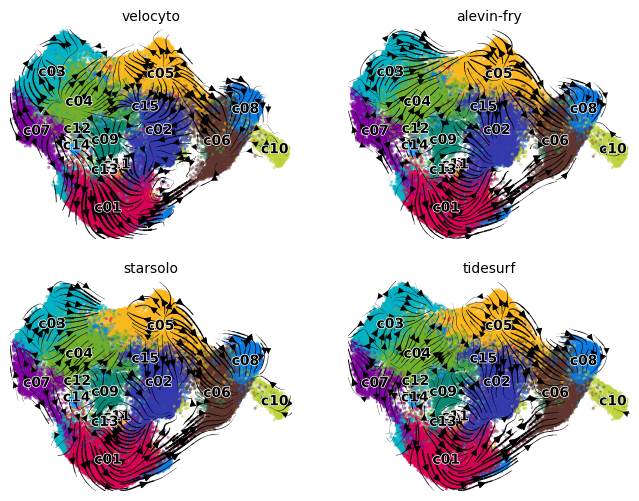

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    for i, (method, adata) in enumerate(adatas_velocity.items()):
        scv.pl.velocity_embedding_stream(
            adata,
            basis="umap",
            color="groups",
            size=20,
            alpha=0.5,
            show=False,
            ax=axs.flat[i],
            title=method,
        )
fig.savefig(os.path.join(FIG_DIR, "velocity_embedding_stream.png"), dpi=200)

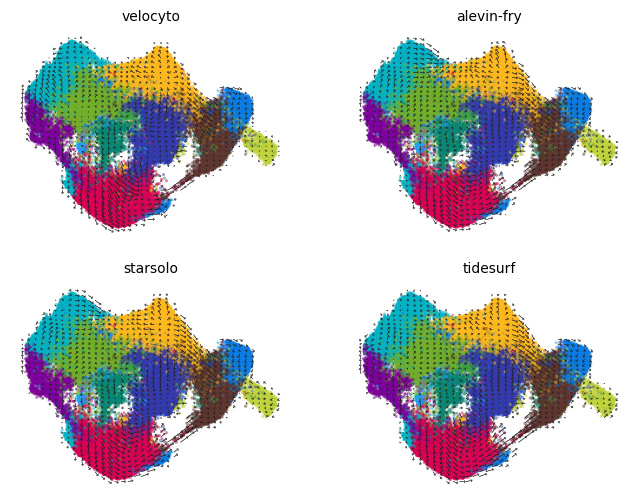

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    for i, (method, adata) in enumerate(adatas_velocity.items()):
        scv.pl.velocity_embedding_grid(
            adata,
            basis="umap",
            color="groups",
            size=20,
            alpha=0.5,
            arrow_length=2,
            arrow_size=(10, 18, 8),
            density=0.8,
            show=False,
            ax=axs.flat[i],
            title=method,
        )
fig.savefig(os.path.join(FIG_DIR, "velocity_embedding_grid.png"), dpi=200)

In [44]:
# Compute pairwise common genes
common_genes_velocities = {
    method_1 + "_" + method_2: pd.Index(
        set(adatas_velocity[method_1].var_names).intersection(
            set(adatas_velocity[method_2].var_names)
        )
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}
for comp, genes in common_genes_velocities.items():
    print(f"{comp}: {len(genes)} common genes")

velocyto_alevin-fry: 7036 common genes
velocyto_starsolo: 7118 common genes
velocyto_tidesurf: 7476 common genes
alevin-fry_starsolo: 7870 common genes
alevin-fry_tidesurf: 7707 common genes
starsolo_tidesurf: 7790 common genes


In [45]:
# Create dictionary for easier comparisons
comp_dict_velocities = {
    method_1 + "_" + method_2: (
        adatas_velocity[method_1][
            :, common_genes_velocities[method_1 + "_" + method_2]
        ],
        adatas_velocity[method_2][
            :, common_genes_velocities[method_1 + "_" + method_2]
        ],
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}

In [46]:
# Compare velocities: cosine similarities per cell
velocities_cosine = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "cosine_similarity": cosine(
                    adata_1.layers["velocity"].toarray(),
                    adata_2.layers["velocity"].toarray(),
                    axis=1,
                ),
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_velocities.items()
    ]
).reset_index(drop=True)
velocities_cosine.to_parquet(
    os.path.join(OUT_DIR, "velocities_cosine.parquet.gz"), compression="gzip"
)

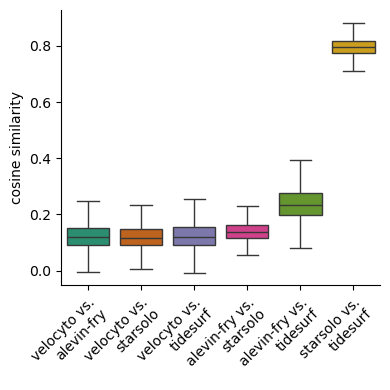

In [47]:
# Boxplots of cosine similarities of velocities
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_cosine,
    x="comparison",
    y="cosine_similarity",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax,
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[lab.get_text().replace("_", " vs.\n") for lab in ax.get_xticklabels()],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax.set_ylabel("cosine similarity")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_cosine.png"), dpi=200)

In [48]:
# Pearson correlation of velocities per gene
velocities_corr = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "pearsonr": stats.pearsonr(
                    adata_1.layers["velocity"].toarray(),
                    adata_2.layers["velocity"].toarray(),
                    axis=0,
                )[0],
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_velocities.items()
    ]
).reset_index(drop=True)
velocities_corr.to_parquet(
    os.path.join(OUT_DIR, "velocities_corr.parquet.gz"), compression="gzip"
)

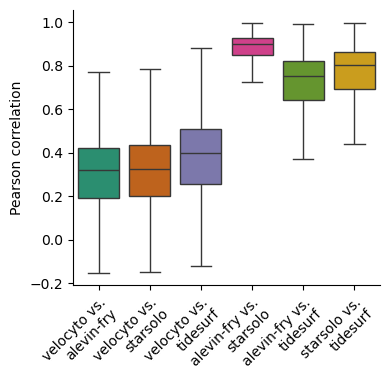

In [49]:
# Boxplots of pearson correlation of velocities
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_corr,
    x="comparison",
    y="pearsonr",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax,
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[lab.get_text().replace("_", " vs.\n") for lab in ax.get_xticklabels()],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax.set_ylabel("Pearson correlation")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_corr.png"), dpi=200)

In [50]:
# Compute pairwise common velocity genes (velocyto has much fewer genes!)
common_genes_velo = {
    method_1 + "_" + method_2: pd.Index(
        set(
            adatas_velocity[method_1][
                :, adatas_velocity[method_1].var["velocity_genes"]
            ].var_names
        )
        .union(
            set(
                adatas_velocity[method_2][
                    :, adatas_velocity[method_2].var["velocity_genes"]
                ].var_names
            )
        )
        .intersection(adatas_velocity[method_1].var_names)
        .intersection(adatas_velocity[method_2].var_names)
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}

for method, adata in adatas_velocity.items():
    print(f"{method}: {adata.var['velocity_genes'].sum()} velocity genes")

for comp, genes in common_genes_velo.items():
    print(f"{comp}: {len(genes)} common genes")

velocyto: 267 velocity genes
alevin-fry: 443 velocity genes
starsolo: 473 velocity genes
tidesurf: 531 velocity genes
velocyto_alevin-fry: 492 common genes
velocyto_starsolo: 512 common genes
velocyto_tidesurf: 547 common genes
alevin-fry_starsolo: 524 common genes
alevin-fry_tidesurf: 573 common genes
starsolo_tidesurf: 590 common genes


In [51]:
# Compute pairwise common highly variable genes (all genes for velocyto as it has fewer genes)
common_genes_hvg = {
    method_1 + "_" + method_2: pd.Index(
        set(
            adatas_velocity[method_1][
                :, adatas_velocity[method_1].var["highly_variable"]
            ].var_names
        )
        .union(
            set(
                adatas_velocity[method_2][
                    :, adatas_velocity[method_2].var["highly_variable"]
                ].var_names
            )
        )
        .intersection(adatas_velocity[method_1].var_names)
        .intersection(adatas_velocity[method_2].var_names)
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}

for method, adata in adatas_velocity.items():
    print(f"{method}: {adata.var['highly_variable'].sum()} highly variable genes")

for comp, genes in common_genes_hvg.items():
    print(f"{comp}: {len(genes)} common genes")

velocyto: 2000 highly variable genes
alevin-fry: 2000 highly variable genes
starsolo: 2000 highly variable genes
tidesurf: 2000 highly variable genes
velocyto_alevin-fry: 2087 common genes
velocyto_starsolo: 2216 common genes
velocyto_tidesurf: 2259 common genes
alevin-fry_starsolo: 2440 common genes
alevin-fry_tidesurf: 2435 common genes
starsolo_tidesurf: 2544 common genes


In [52]:
# Create dictionaries for easier comparisons
comp_dict_velo = {
    method_1 + "_" + method_2: (
        adatas_velocity[method_1][:, common_genes_velo[method_1 + "_" + method_2]],
        adatas_velocity[method_2][:, common_genes_velo[method_1 + "_" + method_2]],
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}

comp_dict_hvg = {
    method_1 + "_" + method_2: (
        adatas_velocity[method_1][:, common_genes_hvg[method_1 + "_" + method_2]],
        adatas_velocity[method_2][:, common_genes_hvg[method_1 + "_" + method_2]],
    )
    for method_1, method_2 in combinations(adatas_velocity, 2)
}

In [53]:
# Compare velocities: cosine similarities per cell
velocities_cosine_velo = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "cosine_similarity": cosine(
                    adata_1.layers["velocity"].toarray(),
                    adata_2.layers["velocity"].toarray(),
                    axis=1,
                ),
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_velo.items()
    ]
).reset_index(drop=True)
velocities_cosine_velo.to_parquet(
    os.path.join(OUT_DIR, "velocities_velo_cosine.parquet.gz"), compression="gzip"
)

In [54]:
# Compare velocities: cosine similarities per cell
velocities_cosine_hvgs = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "cosine_similarity": cosine(
                    adata_1.layers["velocity"].toarray(),
                    adata_2.layers["velocity"].toarray(),
                    axis=1,
                ),
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_hvg.items()
    ]
).reset_index(drop=True)
velocities_cosine_hvgs.to_parquet(
    os.path.join(OUT_DIR, "velocities_hvg_cosine.parquet.gz"), compression="gzip"
)

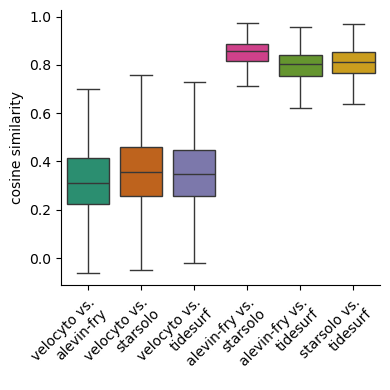

In [55]:
# Boxplots of cosine similarities of velocities: velocity genes
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_cosine_velo,
    x="comparison",
    y="cosine_similarity",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax,
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[lab.get_text().replace("_", " vs.\n") for lab in ax.get_xticklabels()],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax.set_ylabel("cosine similarity")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_velo_cosine.png"), dpi=200)

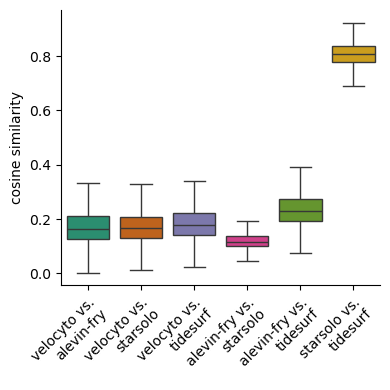

In [56]:
# Boxplots of cosine similarities of velocities: hvgs
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_cosine_hvgs,
    x="comparison",
    y="cosine_similarity",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax,
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[lab.get_text().replace("_", " vs.\n") for lab in ax.get_xticklabels()],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax.set_ylabel("cosine similarity")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_hvg_cosine.png"), dpi=200)

In [57]:
# Compare velocities: Pearson correlation per gene
velocities_corr_velo = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "pearsonr": stats.pearsonr(
                    adata_1.layers["velocity"].toarray(),
                    adata_2.layers["velocity"].toarray(),
                    axis=0,
                )[0],
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_velo.items()
    ]
).reset_index(drop=True)
velocities_corr_velo.to_parquet(
    os.path.join(OUT_DIR, "velocities_velo_corr.parquet.gz"), compression="gzip"
)

In [58]:
# Compare velocities: Pearson correlation per gene
velocities_corr_hvgs = pd.concat(
    [
        pd.DataFrame(
            data={
                "comparison": comp,
                "pearsonr": stats.pearsonr(
                    adata_1.layers["velocity"].toarray(),
                    adata_2.layers["velocity"].toarray(),
                    axis=0,
                )[0],
            }
        )
        for comp, (adata_1, adata_2) in comp_dict_hvg.items()
    ]
).reset_index(drop=True)
velocities_corr_hvgs.to_parquet(
    os.path.join(OUT_DIR, "velocities_hvg_corr.parquet.gz"), compression="gzip"
)

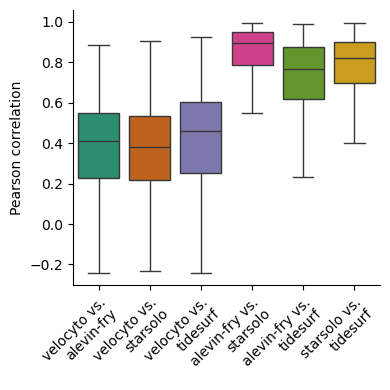

In [59]:
# Boxplots of Pearson correlation of velocities: velocity genes
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_corr_velo,
    x="comparison",
    y="pearsonr",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax,
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[lab.get_text().replace("_", " vs.\n") for lab in ax.get_xticklabels()],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax.set_ylabel("Pearson correlation")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_velo_corr.png"), dpi=200)

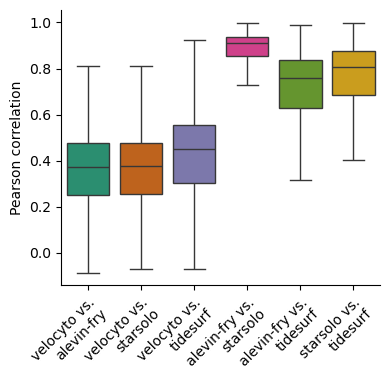

In [60]:
# Boxplots of Pearson correlation of velocities: hvgs
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=velocities_corr_hvgs,
    x="comparison",
    y="pearsonr",
    hue="comparison",
    palette="Dark2",
    showfliers=False,
    ax=ax,
)
ax.set_xlabel("")
ax.set_xticks(
    ticks=ax.get_xticks(),
    labels=[lab.get_text().replace("_", " vs.\n") for lab in ax.get_xticklabels()],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax.set_ylabel("Pearson correlation")

sns.despine(fig)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "velocities_hvg_corr.png"), dpi=200)

In [63]:
# Run PAGA
# Extract subsets of clusters on which the authors ran PAGA
subgroups = ["c01", "c02", "c03", "c04", "c07"]
adata_reference_subset = adatas_common["reference"][
    adatas_common["reference"].obs["groups"].isin(subgroups)
]
adatas_paga = {
    method: adata[adata.obs["groups"].isin(subgroups)].copy()
    for method, adata in adatas_velocity.items()
}

# Compute neighborhood graph for reference data
sc.pp.neighbors(adata_reference_subset, n_pcs=30, n_neighbors=30)

# Transfer neighborhood graph to other datasets and compute moments,
# velocity, and PAGA
for method, adata in adatas_paga.items():
    adata.uns["neighbors"] = adata_reference_subset.uns["neighbors"].copy()
    adata.obsp = adata_reference_subset.obsp.copy()
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata, mode="stochastic")
    scv.tl.velocity_graph(adata)
    scv.tl.paga(adata, groups="groups")

computing moments based on connectivities
    finished (0:00:19) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:11) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/31039 [00:00<?, ?cells/s]

    finished (0:00:30) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:05:31) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
computing moments based on connectivities
    finished (0:00:10) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:12) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/31039 [00:00<?, ?cells/s]

    finished (0:00:47) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:51) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
computing moments based on connectivities
    finished (0:00:15) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:13) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/31039 [00:00<?, ?cells/s]

    finished (0:00:51) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
computing moments based on connectivities
    finished (0:00:10) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:12) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/31039 [00:00<?, ?cells/s]

    finished (0:00:56) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:51) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/janschleiche

/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


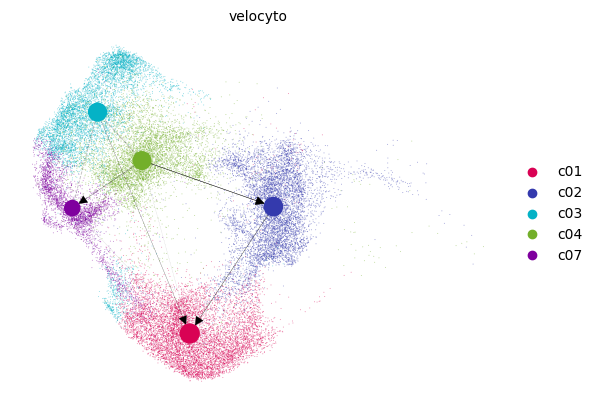

/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/janschleiche

/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


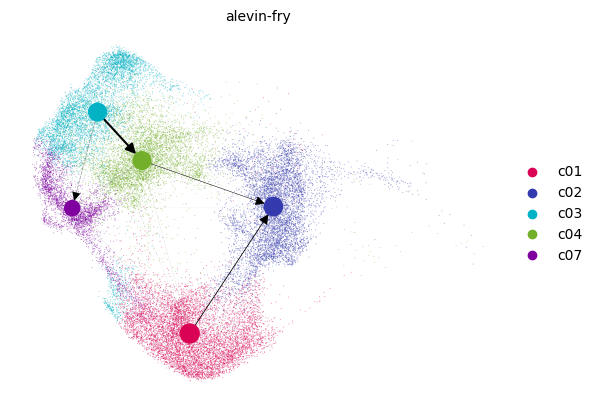

/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/janschleiche

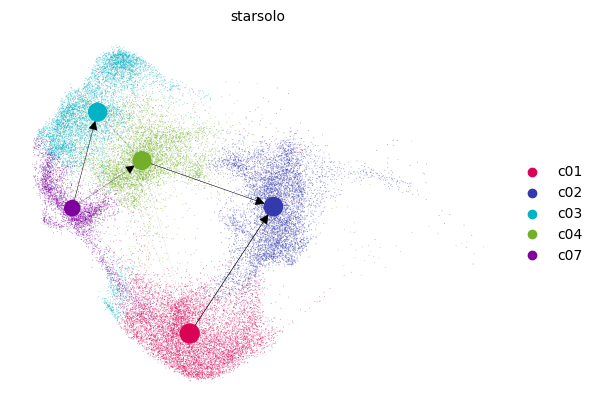

/Users/janschleicher/miniconda3/envs/scanpy_int/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


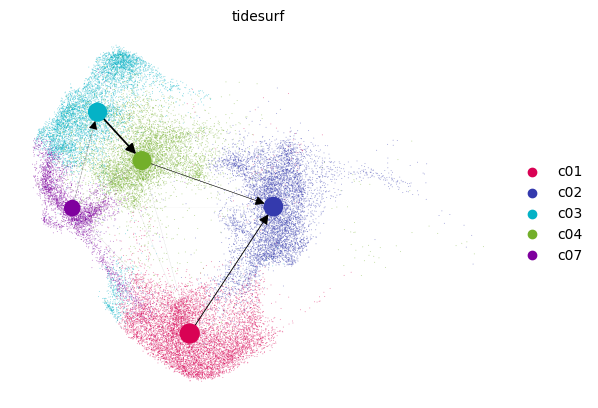

In [65]:
# Plot PAGA
for method, adata in adatas_paga.items():
    scv.pl.paga(adata, basis="umap", color="groups", title=method)

In [66]:
# Save processed AnnData objects
for method, adata in adatas_velocity.items():
    adata.write_h5ad(os.path.join(OUT_DIR, f"adata_{method}.h5ad"), compression="gzip")
    adatas_paga[method].write_h5ad(
        os.path.join(OUT_DIR, f"adata_{method}_paga.h5ad"), compression="gzip"
    )